In [1]:
import WL as wl
import igraph as ig
import make_graph
import binvox_rw
import numpy as np
import torch
import networkx as nx
import grakel
import matplotlib.pyplot as plt
import make_graph_nx
import math
import random
import csv
import torch.nn as nn
from IPython.display import SVG, display
from mpl_toolkits.mplot3d import axes3d, Axes3D
from generate import SuperGenerator
from evolution import mutate
from utils import generate_z,slide
from make_graph_nx import return_label
G=SuperGenerator()
with open ('chair1.binvox','rb')    as f1:
    model1 =binvox_rw.read_as_3d_array(f1)
with open ('chair4.binvox','rb')as f2:
    model2=binvox_rw.read_as_3d_array(f2)

def z_and_Gz(G):
    z=generate_z()
    voxels = G.generate(z, 'Chair')
    bool_voxels = voxels>0.5
    #tr_vx=torch.transpose(bool_voxels,1,2)
    return z.to('cpu').detach().numpy().copy(),bool_voxels.to('cpu').detach().numpy().copy()

def scatter_z_and_Gz(G,n):
    rate=4
    zs=[]
    voxels=[]
    z1=generate_z()
    voxel1=G.generate(z1,'Chair')
    bool_voxels1=voxel1>0.5
    voxels.append(bool_voxels1.to('cpu').detach().numpy().copy())
    zs.append(z1.to('cpu').detach().numpy().copy())
    for i in range(0,n-1):
        zx=generate_z().to('cpu').detach().numpy()
        dis=np.linalg.norm(zx-zs[i])
        zx=zs[i]+((zx-zs[i])*random.random()*rate/dis)
        zs.append(zx.copy())
        voxelx=G.generate(torch.from_numpy(zx),'Chair')
        bool_voxelsx=voxelx>0.5
        voxels.append(bool_voxelsx.to('cpu').detach().numpy().copy())
        
    return zs,voxels
    
    
    
    
def vec_dis(zs,n):
    tmp_index=np.arange(n)
    xx, yy = np.meshgrid(tmp_index, tmp_index)
    zs_np=np.array(zs)
    distances=np.linalg.norm(zs_np[xx]-zs_np[yy], axis=2)
    return distances

def coords_based_sim(voxels,n):
    sim=[]
    for i in range(n):
        sim.append([])
        for j in range(n):
            sim[i].append(get_sim_two(voxels[i],voxels[j]))
    return np.array(sim)
    

def load_file_data(container,n):
    for i in range(1,n+1,1):
        with open ('../DeepIE3D_Training/data/chair64_512/chair'+str(i)+'.binvox','rb') as f:
            model=binvox_rw.read_as_3d_array(f)
            container.append(model.data)
    return container

def cmb_matrix(cnts,n):
    X=np.zeros((n,n))
    tmp_index=np.arange(n)
    xx, yy = np.meshgrid(tmp_index, tmp_index)
    cnts_np=np.array(cnts)
    multiples=cnts_np[xx]*cnts_np[yy]
    return multiples

def WeisfeilerLehman(voxels,n,_n_iter):
    trimed_voxels=[]
    G=[]
    for i in range(n):
        Gi,trimed_voxeli=make_graph_nx.convert_array_to_graph(voxels[i])
        G.append(Gi)
        trimed_voxels.append(trimed_voxeli)
    G_grakel=grakel.graph_from_networkx(G, node_labels_tag='label')
    gk=grakel.WeisfeilerLehman(n_iter=_n_iter,normalize=True)
    K=gk.fit_transform(G_grakel)
    return K,trimed_voxels,G

def single_WeisfeilerLehman(voxels1):
    G1,trimed_voxel=make_graph_nx.convert_array_to_graph(voxels1)
    G=[G1]
    svg = SVG(nx.nx_agraph.to_agraph(G1).draw(prog='fdp', format='svg'))
    display(svg)
    G_grakel=grakel.graph_from_networkx(G, node_labels_tag='label')
    gk=grakel.WeisfeilerLehman()
    K=gk.fit_transform(G_grakel)
    return K,G1

def visualize(voxels):
    colors='red'
    fig = plt.figure()
    ax3 = fig.gca(projection='3d')
    ax3.voxels(voxels, facecolors=colors, edgecolor='k')
    plt.show()
    
def make_binvox(data,filename):
    voxels=binvox_rw.Voxels(data,[64,64,64], [0,0,0], 1, 'xyz')
    voxels.write('../DeepIE3D_Training/data/ex/'+filename+'.binvox')
    
def make_pooled_binvox(data,filename,dim):
    voxels=binvox_rw.Voxels(data,[dim,dim,dim], [0,0,0], 1, 'xyz')
    voxels.write('../DeepIE3D_Training/data/ex/'+filename+str(dim)+'.binvox')
    
def save_voxels(voxels,n,op=None):
    for i in range(n):
        voxel=binvox_rw.Voxels(voxels[i],[64,64,64], [0,0,0], 1, 'xyz')
        if op==None:
            voxel.write('../DeepIE3D_Training/data/ex/generated'+str(i)+'.binvox')
        else:
            voxel.write('../DeepIE3D_Training/data/ex/generated'+op+str(i)+'.binvox')

def get_sim_two(voxels1,voxels2):
    tensor1=list_to_tensor(voxels1)
    tensor2=list_to_tensor(voxels2)
    model1 = torch.nonzero(tensor1)
    model2=torch.nonzero(tensor2)
    voxel_count1 = len(model1)
    voxel_count2 = len(model2)
    same_voxel_count=0
    for (x, y, z) in model1:
        if voxels2[x][y][z]:
            same_voxel_count += 1
    return (same_voxel_count*same_voxel_count)/(voxel_count1*voxel_count2)

def list_to_tensor(voxels):
    return torch.from_numpy(np.array(voxels))

def scatter_viz(t,y1,y2):
    fig, ax = plt.subplots()

    c1,c2 = "blue","green"      # 各プロットの色
    l1,l2 = "coords","kernel"   # 各ラベル

    ax.set_xlabel('x')  # x軸ラベル
    ax.set_ylabel('y')  # y軸ラベル
    ax.set_title(r'$\sin(x)$ and $\cos(x)$') # グラフタイトル
    # ax.set_aspect('equal') # スケールを揃える
    ax.grid()            # 罫線
    ax.set_xlim([0, 20]) # x方向の描画範囲を指定
    ax.set_ylim([0, 1])    # y方向の描画範囲を指定
    ax.scatter(t, y1, color=c1, label=l1)
    ax.scatter(t, y2, color=c2, label=l2)
    ax.legend(loc=0)    # 凡例
    fig.tight_layout()  # レイアウトの設定
    # plt.savefig('hoge.png') # 画像の保存
    plt.show()

def write_kernel_to_csv(K):
    with open('../DeepIE3D_Training/similarity.csv','w') as f:
        writer=csv.writer(f)
        writer.writerows(K)
        
def maxpool(voxel,kernel_size):
    tensor=torch.Tensor(voxel).unsqueeze_(0).unsqueeze_(0)
    m=nn.MaxPool3d(kernel_size,stride=kernel_size)
    out=m(tensor).squeeze_(0).squeeze_(0)
    make_pooled_binvox(out.to('cpu').detach().numpy(),'pooled',64/kernel_size)
    
    


import sys;print(sys.executable)
'''
instance=wl.WeisfeilerLehman()
graphs=[]
g=ig.Graph()
g.add_vertices(5)
g.add_edges([(0,1),(1,2),(0,3),(1,4)])
g.vs["label"]=[0,0,0,0,0]
#layout = g.layout("kk")
#ig.plot(g, layout = layout)
graphs.append(g)
print(instance.fit_transform(graphs,4) )

coords_arr = [[[False for k in range(64)] for j in range(64)] for i in range(64)]   #voxelが存在しているところが1
for i in range(64):
    coords_arr[i][0][0]=True
    coords_arr[i][1][0]=True
    coords_arr[i][2][0]=True
#print(make_graph.convert_array_to_graph(model.data))
'''

/home/ibalab/anaconda3/bin/python


'\ninstance=wl.WeisfeilerLehman()\ngraphs=[]\ng=ig.Graph()\ng.add_vertices(5)\ng.add_edges([(0,1),(1,2),(0,3),(1,4)])\ng.vs["label"]=[0,0,0,0,0]\n#layout = g.layout("kk")\n#ig.plot(g, layout = layout)\ngraphs.append(g)\nprint(instance.fit_transform(graphs,4) )\n\ncoords_arr = [[[False for k in range(64)] for j in range(64)] for i in range(64)]   #voxelが存在しているところが1\nfor i in range(64):\n    coords_arr[i][0][0]=True\n    coords_arr[i][1][0]=True\n    coords_arr[i][2][0]=True\n#print(make_graph.convert_array_to_graph(model.data))\n'

In [2]:

'''
G1=nx.Graph()
G1.add_nodes_from([0,1,2,3])
G1.add_edges_from([(0,1),(1,2),(0,3)])
nx.set_node_attributes(G1, {0:0, 1:0, 2:0,3:1}, 'label')
G1.add_node(4,label=2)
print(G1.nodes[4]['label'])
G=[G1]
G_grakel=grakel.graph_from_networkx(G, node_labels_tag='label')
gk=grakel.WeisfeilerLehman()
K=gk.fit_transform(G_grakel)
print(K)


zs=[]
voxels=[]
n=10
for i in range(n):
    z,voxel=z_and_Gz(G)
    zs.append(z)
    voxels.append(voxel)
#zs,voxels=scatter_z_and_Gz(G,n)

distances=vec_dis(zs,n).flatten()
K,trimed_voxels,_=WeisfeilerLehman(voxels,n,30)
coords_base_sim_oneline=coords_based_sim(voxels,n).flatten()
K_oneline=np.array(K).flatten()
save_voxels(voxels,n,"notrim")
save_voxels(trimed_voxels,n)
scatter_viz(distances,coords_base_sim_oneline,K_oneline)

z,voxel=z_and_Gz(G)
voxel_slided=slide(voxel,1)
K,_,_=WeisfeilerLehman([voxel,voxel_slided],2,5)
print(K)
'''

'\nG1=nx.Graph()\nG1.add_nodes_from([0,1,2,3])\nG1.add_edges_from([(0,1),(1,2),(0,3)])\nnx.set_node_attributes(G1, {0:0, 1:0, 2:0,3:1}, \'label\')\nG1.add_node(4,label=2)\nprint(G1.nodes[4][\'label\'])\nG=[G1]\nG_grakel=grakel.graph_from_networkx(G, node_labels_tag=\'label\')\ngk=grakel.WeisfeilerLehman()\nK=gk.fit_transform(G_grakel)\nprint(K)\n\n\nzs=[]\nvoxels=[]\nn=10\nfor i in range(n):\n    z,voxel=z_and_Gz(G)\n    zs.append(z)\n    voxels.append(voxel)\n#zs,voxels=scatter_z_and_Gz(G,n)\n\ndistances=vec_dis(zs,n).flatten()\nK,trimed_voxels,_=WeisfeilerLehman(voxels,n,30)\ncoords_base_sim_oneline=coords_based_sim(voxels,n).flatten()\nK_oneline=np.array(K).flatten()\nsave_voxels(voxels,n,"notrim")\nsave_voxels(trimed_voxels,n)\nscatter_viz(distances,coords_base_sim_oneline,K_oneline)\n\nz,voxel=z_and_Gz(G)\nvoxel_slided=slide(voxel,1)\nK,_,_=WeisfeilerLehman([voxel,voxel_slided],2,5)\nprint(K)\n'

In [3]:

voxels=[]
n=2
load_file_data(voxels,n)
maxpool(voxels[0],2)
maxpool(voxels[0],4)
#K,trimed_voxels,G=WeisfeilerLehman(voxels,n,1)

#print(coords_based_sim(voxels,n))
#print(K)
#for i in range(n):
    #visualize(trimed_voxels[i])



torch.Size([1, 1, 64, 64, 64]) torch.Size([32, 32, 32]) tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
       

[[1.         0.14285714]
 [0.14285714 1.        ]]


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


VertexHistogram(n_jobs=None, normalize=False, sparse='auto', verbose=False)
[[1.       0.533745]
 [0.533745 1.      ]]


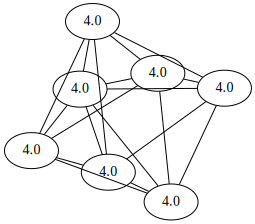

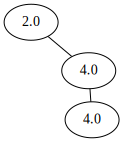

In [4]:
m=64
coords_arr = [[[False for k in range(m)] for j in range(m)] for i in range(m)]
coords_arr2=[[[False for k in range(m)] for j in range(m)] for i in range(m)]

for i in range(5):
    for j in range(5):
        for k in range(5):
             if np.linalg.norm(np.array([i-2,j-2,k-2]))<=1 :
                    coords_arr[i][j][k]=True
'''
coords_arr[0][0][0]=True
coords_arr[0][1][0]=True
coords_arr[0][2][0]=True
coords_arr[0][3][0]=True
coords_arr[0][0][2]=True
coords_arr[0][1][2]=True
coords_arr[0][2][2]=True
coords_arr[0][3][2]=True
coords_arr[2][0][0]=True
coords_arr[2][1][0]=True
coords_arr[2][2][0]=True
coords_arr[2][3][0]=True
coords_arr[2][0][2]=True
coords_arr[2][1][2]=True
coords_arr[2][2][2]=True
coords_arr[2][3][2]=True

coords_arr[0][3][1]=True
coords_arr[1][3][0]=True
coords_arr[0][1][1]=True
coords_arr[1][1][0]=True
coords_arr[1][3][1]=True
coords_arr[2][3][1]=True
coords_arr[1][3][2]=True
coords_arr[2][1][1]=True
coords_arr[1][1][2]=True
'''




coords_arr2[2][2][2]=True
coords_arr2[1][2][2]=True
coords_arr2[0][2][2]=True
coords_arr2[0][0][0]=True

voxels=[]
voxels.append(coords_arr)
voxels.append(coords_arr2)
print(coords_based_sim(voxels,2))
make_binvox(np.array(coords_arr),'minichair')
K,trimed_voxels,G=WeisfeilerLehman(voxels,2,1)
print(K)
svg = SVG(nx.nx_agraph.to_agraph(G[0]).draw(prog='fdp', format='svg'))
display(svg)
svg = SVG(nx.nx_agraph.to_agraph(G[1]).draw(prog='fdp', format='svg'))
display(svg)
